<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/data-exploration/single_image_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install tf-nightly-2.0-preview
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import io
# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required


%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

You have version 2.0.0-dev20190513


In [3]:
## load data fom google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


In [5]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"model/"} {"/tmp"}

Copying gs://vaa2114_dl_2019/model/level3_window_800.h5...
Copying gs://vaa2114_dl_2019/model/level7_window_50.h5...
Copying gs://vaa2114_dl_2019/model/level5_window_400.h5...
| [3/3 files][239.6 MiB/239.6 MiB] 100% Done                                    
Operation completed over 3 objects/239.6 MiB.                                    


In [0]:
!mkdir /tmp/model_prediction

In [0]:
def getSlide_Mask(slide_file, tumor_mask_file):

  

  slide = open_slide(slide_file)
  tumor_mask = open_slide(tumor_mask_file)
  
  # some slides have more than 8 levels, since we will only use the first 8 levels 
  # we will only assert that the first 8 levels have the appropriate dimensions 
  for i in range(8):  
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide, tumor_mask

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
  
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
slide_file= '/content/drive/My Drive/tumor_101.tif'
tumor_mask_file  = '/content/drive/My Drive/tumor_101_mask.tif'

  
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

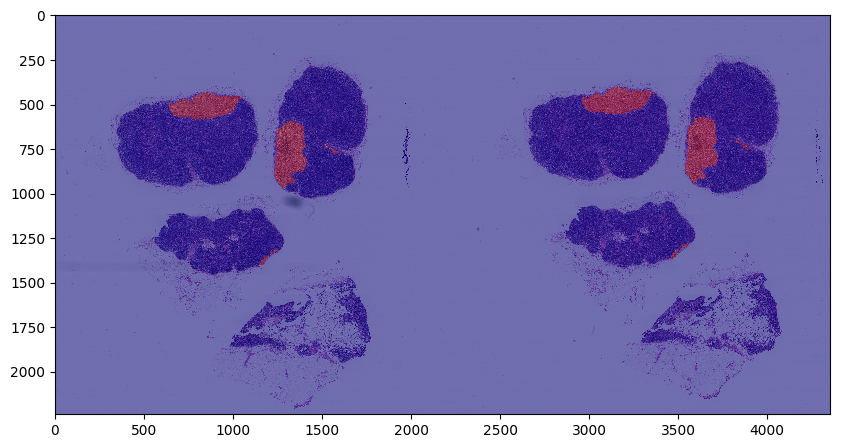

In [9]:
slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = mask_image_orig[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(mask_image_orig, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
level5_window_400 = load_model('/tmp/model/level5_window_400.h5')
level3_window_800 = load_model('/tmp/model/level3_window_800.h5')


In [0]:
model_dict = {}
for i in os.listdir('/tmp/model'):
  name = i.split('.')[0]
  level = name[5]
  window = name[14:]
  model_dict[name] = {'level' : level,
                      'window': window}

In [0]:
heat_map = slide_image_orig[:,:,0]*0

In [0]:
LEVEL = 5
down_sample = int(slide.level_downsamples[int(LEVEL)])
x = 700 * down_sample
y = 400 * down_sample
window_3 = 800
window_5 = 400
window_7 = 50


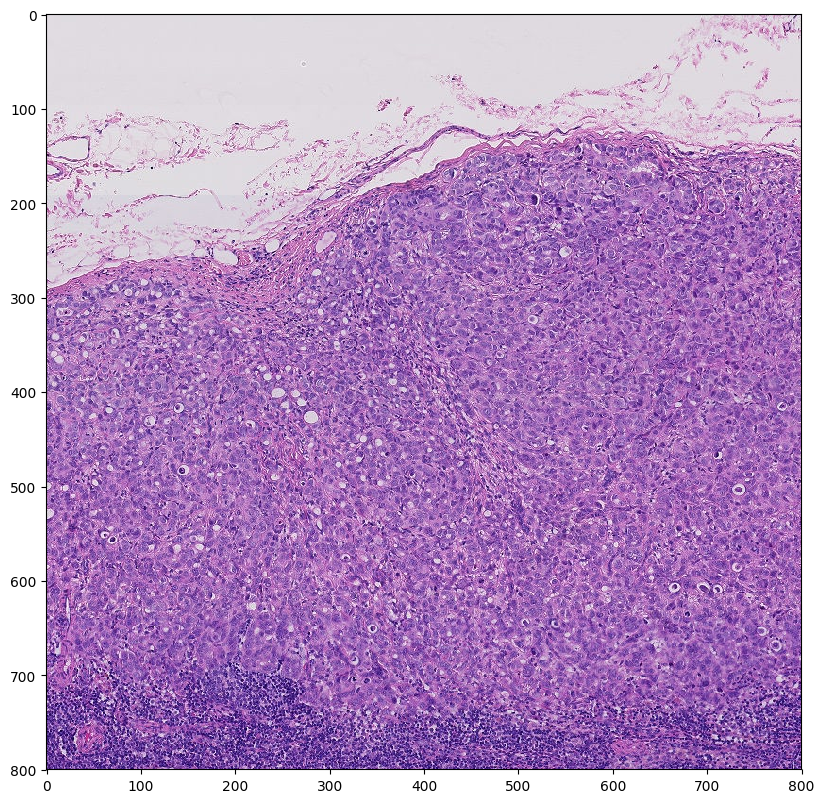

In [26]:
slide_image_pred = read_slide(slide, 
                         x=x, 
                         y=y, 
                         level=3, 
                         width= window_3, 
                         height= window_3)

mask_image_pred = read_slide(tumor_mask, 
                         x=x, 
                         y=y, 
                         level=3, 
                         width= window_3, 
                         height= window_3)

mask_image_pred = mask_image_pred[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_pred)
#plt.imshow(mask_image_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

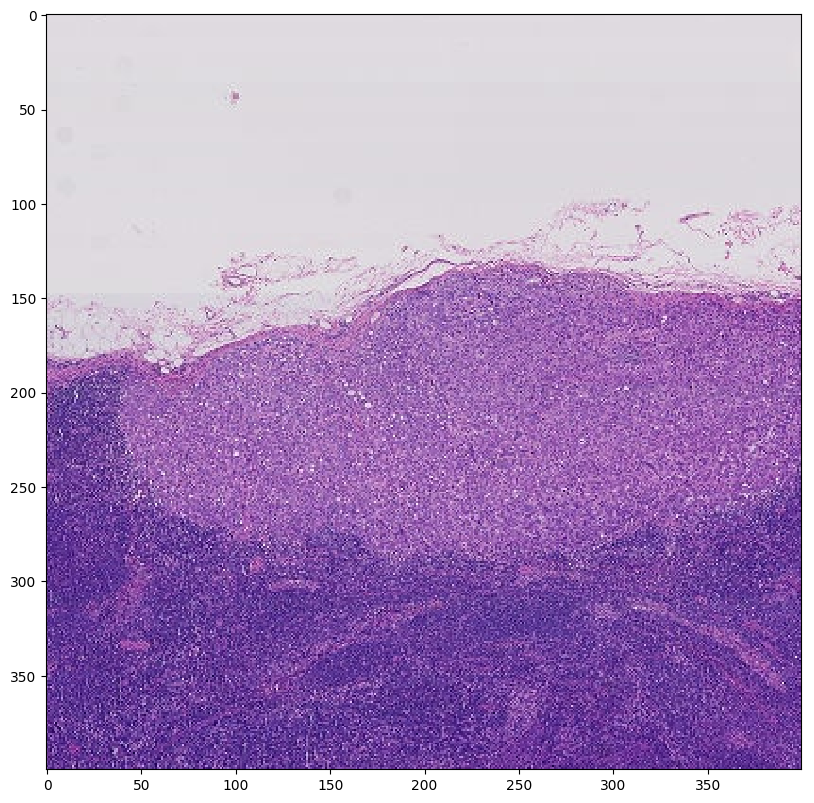

In [31]:
slide_image_pred = read_slide(slide, 
                         x= int(x - window_5*.25*int(slide.level_downsamples[int(5)])), 
                         y= int(y - window_5*.25*int(slide.level_downsamples[int(5)])), 
                         level=5, 
                         width= window_5, 
                         height= window_5
                             )

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_pred)
#plt.imshow(mask_image_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

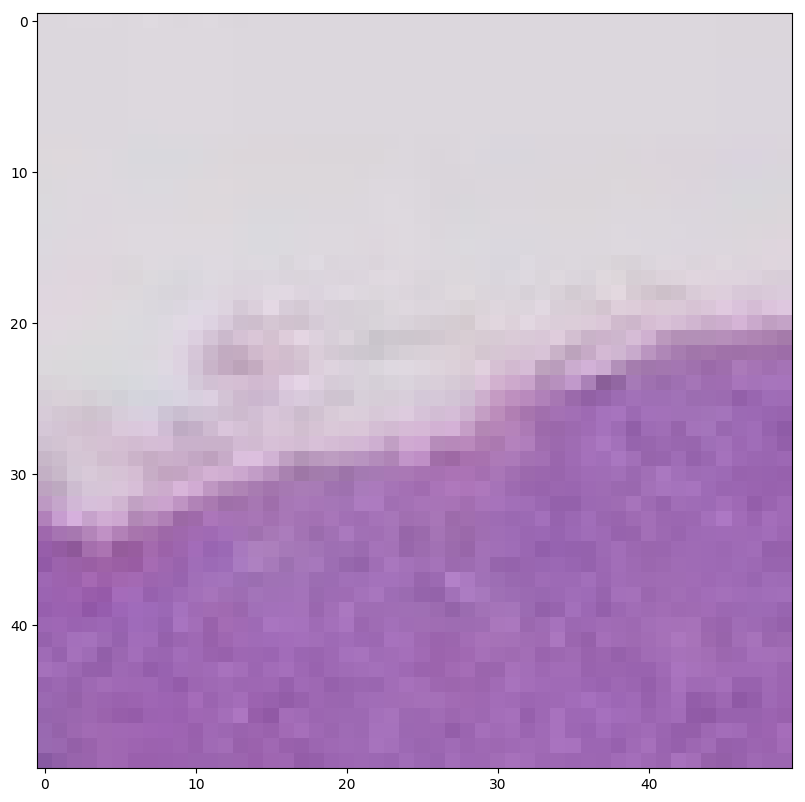

In [32]:
slide_image_pred = read_slide(slide, 
                         x= int(x - window_7*.25*int(slide.level_downsamples[int(7)])), 
                         y= int(y - window_7*.25*int(slide.level_downsamples[int(7)])), 
                         level=7, 
                         width= window_7, 
                         height= window_7
                             )

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_pred)
#plt.imshow(mask_image_pred, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
import cv2
import numpy as np

predict_datagen = ImageDataGenerator(rescale=1./255)

img1 = cv2.resize(slide_image_pred, (160, 160))
img1 = np.array(img1).reshape((1, 160, 160, 3))#do not miss the order in tuple

In [23]:




level5_window_400.predict(img1)

array([[9.9989140e-01, 1.0855498e-04]], dtype=float32)